Includes and constants

In [1]:
from numpy import *
from numpy.random import rand
from matplotlib.pylab import *
import scipy.constants as C
from scipy.interpolate import interp1d

# Define constants
c0    =  C.c             # speed of light
h0    =  C.h             # Planck constant
k0    =  C.k             # Boltzmann constant
EPS   =  1.0e-6          # epsilon
PC    =  3.0856775e+16   # parsec

Miscellaneous auxiliary routines

In [2]:
def Planck(f, T): # Blackbody intensity
    return (2.0*h0*f**3/c0**2)  /  ( exp(h0*f/(k0*T)) - 1.0 )

def create_cloud(NX, NY, NZ):
    # Generate density distribution for the model
    # Peak density 1e4 cm-3  =  1e10 m-3
    I, J, K = indices((NX, NY, NZ), float32)
    I -= (NX-1)/2
    J -= (NY-1)/2
    K -= (NZ-1)/2
    n  = exp(-0.005*(I*I+J*J+K*K))
    n  = 1.0e10*asarray(n, float32)
    if (0):
        imshow(n[NX//2,:,:])
        show(block=True)
        sys.exit()
    return n

def initialise_background_package(NX, NY, NZ):
    # Generate photon package with random position and direction
    u       = rand()
    ct      = sqrt(rand())
    st      = sqrt(1.0-ct*ct)
    phi     = 2.0*pi*rand()
    cp      = cos(phi)
    sp      = sin(phi)
    ###
    if (u<1/6):   #  side X=0
        x, y, z =  EPS,       NY*rand(), NZ*rand()
        u, v, w =  ct,        st*cp,     st*sp
    elif (u<2/6): # side X=NX
        x, y, z =  NX-EPS,    NY*rand(), NZ*rand()
        u, v, w = -ct,        st*cp,     st*sp
    elif (u<3/6): # side Y=0
        x, y, z =  NX*rand(), EPS,       NZ*rand()
        u, v, w =  st*cp,     ct,        st*sp
    elif (u<4/6): # side Y=NY
        x, y, z =  NX*rand(), NY-EPS,    NZ*rand()
        u, v, w =  st*cp,     -ct,       st*sp
    elif (u<5/6): # side Z=0
        x, y, z =  NX*rand(), NY*rand(), EPS
        u, v, w =  st*cp,     st*sp,     ct
    else:         # side Z=NZ
        x, y, z =  NX*rand(), NY*rand(), NX-EPS
        u, v, w =  st*cp,     st*sp,     -ct
    return x, y, z, u, v, w

def get_step_length(x, y, z,  u, v, w):
    # take step to next cell boundary, return the distance without updating (x,y,z)
    if (u>0.0):
        dx  =  (1.0+EPS-fmod(x, 1.0)) / u
    else:
        dx  =     -(EPS+fmod(x, 1.0)) / u
    if (v>0.0):
        dy  =  (1.0+EPS-fmod(y, 1.0)) / v
    else:
        dy  =     -(EPS+fmod(y, 1.0)) / v
    if (w>0.0):
        dz  =  (1.0+EPS-fmod(z, 1.0)) / w
    else:
        dz  =     -(EPS+fmod(z, 1.0)) / w
    return min([dx, dy, dz])

def get_cell_indices(x, y, z, NX, NY, NZ):
    # Return integer cell indices for position (x, y, z)
    if ((x<=0.0)|(x>=NX)): return -1, -1, -1
    if ((y<=0.0)|(y>=NY)): return -1, -1, -1
    if ((z<=0.0)|(z>=NZ)): return -1, -1, -1
    return  int(floor(x)), int(floor(y)), int(floor(z))


def read_dust_file(name):
    # Read dust optical properties from text file
    lines  =  open(name).readlines()
    A      =  float(lines[1].split()[0])       # dust-to-gas number ratio
    B      =  float(lines[2].split()[0])*0.01  # grain size [m]
    d      =  loadtxt(name, skiprows=4)
    freq   =  d[:,0]
    g      =  d[:,1]
    Kabs   =  A * pi*B**2 * d[:,2]  # cross section per H-atom [m2/H]
    Ksca   =  A * pi*B**2 * d[:,3]  # cross section per H-atom [m2/H]
    return freq, g, Kabs, Ksca

def isotropic_scattering(u, v, w):
    # just random direction uniformly over 4 pi solid angle
    cos_theta =  -1.0+2.0*rand()
    sin_theta =  sqrt(1.0-cos_theta**2)
    phi       =  2.0*pi*rand()
    u         =  sin_theta*cos(phi)
    v         =  sin_theta*sin(phi)
    w         =  cos_theta
    return u, v, w


def get_integration_weights(freq):
    """
    Return integration weights for trapezoidal integration over frequency axis,
    given the frequency grid freq.
    """
    N       =  len(freq)
    weights =  zeros(N, float32)
    for i in range(N):   #  loop over intervals
        if (i>0):        #  integral +=  0.5*(y[i]+y[i-1])*(x[i]-x[i-1])
            weights[i] += 0.5*(freq[i]-freq[i-1])
        if (i<(N-1)):    #  integral +=  0.5*(y[i]+y[i+1])*(x[i+1]-x[i])
            weights[i] += 0.5*(freq[i+1]-freq[i])
    return weights        

Preparations for the runs

In [4]:
NX, NY, NZ  =  32, 32, 32     # model dimensions, for coordinates 0.0<x<NX
GL          =  0.1*PC         # define the size of a single cell (0.1 pc)
NPP         =  10000          # default number of photon packages (PP)
n           =  create_cloud(NX, NY, NZ)  # create model densities
 
# Read dust properties, Kabs in units of [m2/H]
freq, g, Kabs0, Ksca0 = read_dust_file("COM.dust")
NF = len(freq)   # number of frequencies

# Make Kabs and Ksca optical depths for unit density n=1 and distance s=GL
Kabs  = Kabs0 * GL
Ksca  = Ksca0 * GL

# Select one frequency (the one closest to V band) for single-frequency runs
ifreq =  argmin(abs(freq-c0/0.55e-6))
f     =  freq[ifreq]

# Calculate number of photons entering the model in one second, divide by NPP
#   => number of photons per single photon package
Ibg     =  1.0e-13*Planck(f, 10000.0)  # diluted T=10000K black body as background
phot_bg =  (Ibg*pi*2*(NX*NY+NX*NZ+NY*NZ)*GL*GL) / (h0*f) / NPP

Basic simulation of a single frequency, still without scattering.

packet       0  ---  0.00 per cent
packet    2000  ---  5.00 per cent
packet    4000  --- 10.00 per cent
packet    6000  --- 15.00 per cent
packet    8000  --- 20.00 per cent
packet   10000  --- 25.00 per cent
packet   12000  --- 30.00 per cent
packet   14000  --- 35.00 per cent
packet   16000  --- 40.00 per cent
packet   18000  --- 45.00 per cent
packet   20000  --- 50.00 per cent
packet   22000  --- 55.00 per cent
packet   24000  --- 60.00 per cent
packet   26000  --- 65.00 per cent
packet   28000  --- 70.00 per cent
packet   30000  --- 75.00 per cent
packet   32000  --- 80.00 per cent
packet   34000  --- 85.00 per cent
packet   36000  --- 90.00 per cent
packet   38000  --- 95.00 per cent
Run time 13.00 seconds


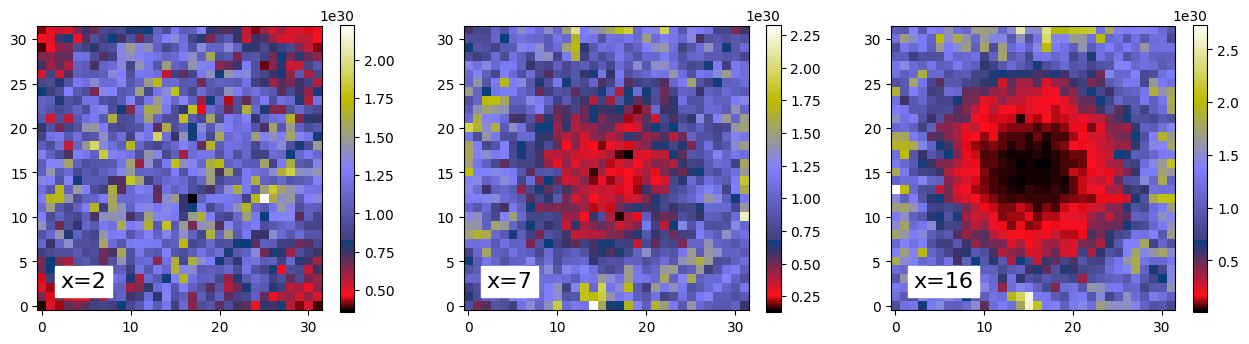

In [5]:
# Simulation of a single frequency, store and plot the absorbed energy
NPP = 40000
ABS = zeros((NX, NY, NZ), float32)  # array for absorbed energy
t0  = time.time()
for ipacket in range(NPP):
    if (ipacket%2000==0):
        print("packet  %6d  --- %5.2f per cent" % (ipacket, 100.0*ipacket/NPP))
    x, y, z, u, v, w  =  initialise_background_package(NX, NY, NZ)
    photons           =  phot_bg
    i, j, k           =  get_cell_indices(x, y, z, NX, NY, NZ)
    while(i>=0):   # while PP remains inside the model volume
        s             =  get_step_length(x, y, z, u, v, w)  # step
        tau           =  s*Kabs[ifreq]*n[i,j,k]             # tau =  s * Kabs * n
        ABS[i,j,k]   +=  photons*(1.0-exp(-tau))            # absorbed part
        photons      *=  exp(-tau)                          # remaining part
        x            +=  s*u                                # coordinate update
        y            +=  s*v
        z            +=  s*w
        i, j, k       =  get_cell_indices(x, y, z, NX, NY, NZ) # index update
print("Run time %.2f seconds" % (time.time()-t0))

# show cross section of the absorbed energy
close(1)
figure(1, figsize=(13, 3.5))
subplots_adjust(left=0.05, right=0.98, bottom=0.09, top=0.91, wspace=0.2)
for i in range(3):
    ax = subplot(1, 3, 1+i)
    ix = [2, 7, NX//2][i]
    imshow(ABS[ix,:,:], cmap=cm.gist_stern)
    text(0.08, 0.08, 'x=%d' % ix, transform=ax.transAxes, size=16, backgroundcolor='w')
    colorbar()
show(block=True)

Single frequency, including isotropic scattering and Russian roulette.

pp       0 ---  0.00 per cent
pp    2000 --- 20.00 per cent
pp    4000 --- 40.00 per cent
pp    6000 --- 60.00 per cent
pp    8000 --- 80.00 per cent
--------------------------------------------------------------------------------
Optical depth 5.815e+00
Run time 3.09 seconds
Model size 3.20 pc,  mean density 3.395e+09 H/m3
Model optical depth  tau_abs = 5.815e+00
--------------------------------------------------------------------------------


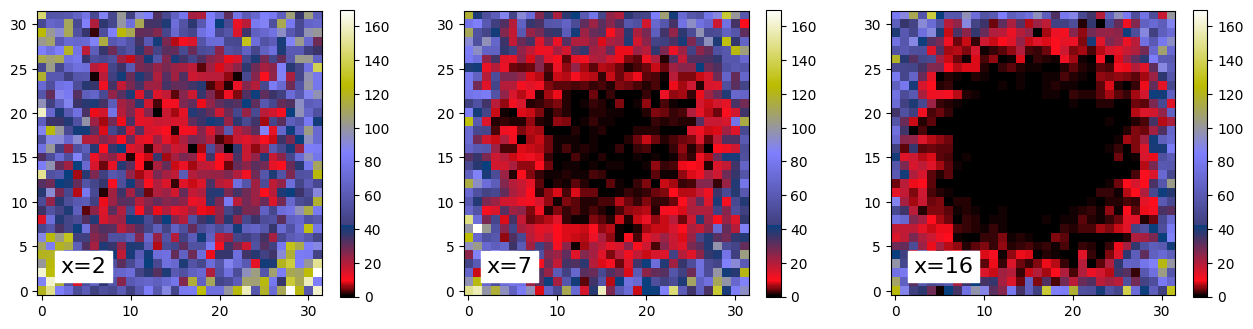

In [6]:
# Simulation of a single frequency, store and plot the absorbed energy
# Includes isotropic scattering and Russian rouletter.
NPP = 10000
ABS = zeros((NX, NY, NZ), float32)  # array for absorbed energy
t0  = time.time()
for pp in range(NPP):
    if (pp%2000==0): print("pp  %6d --- %5.2f per cent" % (pp, 100.0*pp/NPP))
    x, y, z, u, v, w  =  initialise_background_package(NX, NY, NZ)
    photons           =  phot_bg   # initial number of photons in package
    i, j, k           =  get_cell_indices(x, y, z, NX, NY, NZ)
    tau0              =  -log(rand())  # free path for scattering
    while(i>=0):   # while PP remains inside the model volume
        s             =  get_step_length(x, y, z, u, v, w)  # step
        dtaus         =  s*Ksca[ifreq]*n[i,j,k]
        if (dtaus>tau0): # --- partial step and scattering ---
            # distance to in tau to location of scattering
            s           =  tau0/(Ksca[ifreq]*n[i,j,k])  # distance to point of scattering
            tau         =  s*Kabs[ifreq]*n[i,j,k]       # tau(abs.) for this step
            ABS[i,j,k] +=  photons*(1.0-exp(-tau))
            photons    *=  exp(-tau)                    # absorptions on the shorter step
            u, v, w     =  isotropic_scattering(u, v, w) # all photons to new a direction
            tau0        =  -log(rand())                 # new free path
        else:            # --- normal full step ---
            tau         =  s*Kabs[ifreq]*n[i,j,k]       # tau =  s * Kabs * n
            ABS[i,j,k] +=  photons*(1.0-exp(-tau))      # absorbed part
            photons    *=  exp(-tau)                    # remaining part
            tau0       -=  dtaus                        # tau(sca) for the full step
        x         +=  s*u                               # coordinate update
        y         +=  s*v
        z         +=  s*w
        i, j, k    =  get_cell_indices(x, y, z, NX, NY, NZ) # index update
        if (1): # Russian roulette
            if (photons<1.0e-3*phot_bg):  #   true == 1  =  0.5*0 + 0.5*2.0
                if (rand()<0.5):
                    break
                else:
                    photons *= 2.0
# convert absorbed photons to absorbed energy per cell (and per 1 Hz)
# normalised by density
ABS *=  h0*f / n

print("--------------------------------------------------------------------------------")
print("Optical depth %.3e" % (NX*Kabs[ifreq]*mean(ravel(n))))
print("Run time %.2f seconds" % (time.time()-t0))
print("Model size %.2f pc,  mean density %.3e H/m3" % (NX*GL/PC, mean(ravel(n))))
print("Model optical depth  tau_abs = %.3e" % (mean(ravel(n))*Kabs[ifreq]*NX))
print("--------------------------------------------------------------------------------")

# show cross section of the absorbed energy
close(1)
figure(1, figsize=(13, 3.5))
subplots_adjust(left=0.05, right=0.98, bottom=0.09, top=0.91, wspace=0.2)
for i in range(3):
    ax = subplot(1, 3, 1+i)
    ix = [2, 7, NX//2][i]
    imshow(ABS[ix,:,:], cmap=cm.gist_stern, vmin=0, vmax=170.0)
    text(0.08, 0.08, 'x=%d' % ix, transform=ax.transAxes, size=16, backgroundcolor='w')
    colorbar()

Simulate all frequencies and save the integrated absorbed energy to a disk file.

Frequency   1 /  50
Frequency  11 /  50
Frequency  21 /  50
Frequency  31 /  50
Frequency  41 /  50
Run time 17.68 seconds
Ein  1.370e-30,  Eout  2.945e-39 ...  4.493e-22


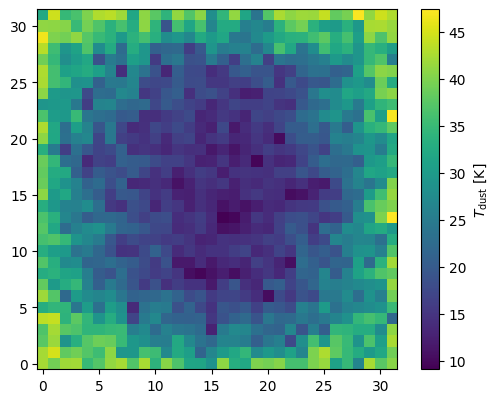

In [8]:
# Simulation of all frequencies, calculate integrated energy and save to file
SUMABS  =  zeros((NX, NY, NZ), float32)  # total absorbed energy
ABS     =  zeros((NX, NY, NZ), float32)  # absorbed photons per 1 Hz band
weights =  get_integration_weights(freq)

NPP     =  1000
t0      =  time.time()
for ifreq in range(NF):
    if (ifreq%10==0): print("Frequency %3d / %3d" % (ifreq+1, NF))
    f          =  freq[ifreq]
    Ibg        =  1.0e-13*Planck(f, 10000.0)  # diluted T=10000K black body as background
    if (0):  # Photons per photon package
        phot_bg    =  (Ibg*pi*2*(NX*NY+NX*NZ+NY*NZ)*GL*GL) / (h0*f) / NPP
    else:     # Use *normalised* photon numbers: true photons / GL^3
        phot_bg    =  (Ibg*pi*2*(NX*NY+NX*NZ+NY*NZ)) / (h0*f*GL) / NPP
    ABS[:,:,:] =  0.0
    for pp in range(NPP):
        # if (pp%1000==0): print("     pp %6d -- %5.2f per cent" % (pp, 100.0*pp/NPP))
        x, y, z, u, v, w  =  initialise_background_package(NX, NY, NZ)
        photons           =  phot_bg
        i, j, k           =  get_cell_indices(x, y, z, NX, NY, NZ)
        tau0              =  -log(rand())  # free path for scattering
        while(i>=0):   # while PP remains inside the model volume
            s             =  get_step_length(x, y, z, u, v, w)  # step
            dtaus         =  s*Ksca[ifreq]*n[i,j,k]
            if (dtaus>tau0): # --- partial step and scattering ---
                # distance to in tau to location of scattering
                s           =  tau0/(Ksca[ifreq]*n[i,j,k])  # distance to point of scattering
                tau         =  s*Kabs[ifreq]*n[i,j,k]       # tau(abs.) for this step
                ABS[i,j,k] +=  photons*(1.0-exp(-tau))
                photons    *=  exp(-tau)                    # absorptions on the shorter step
                u, v, w     =  isotropic_scattering(u, v, w) # all photons to new a direction
                tau0        =  -log(rand())                 # new free path
            else:            # --- normal full step ---
                tau         =  s*Kabs[ifreq]*n[i,j,k]       # tau =  s * Kabs * n
                ABS[i,j,k] +=  photons*(1.0-exp(-tau))      # absorbed part
                photons    *=  exp(-tau)                    # remaining part
                tau0       -=  dtaus                        # tau(sca) for the full step
            x         +=  s*u                               # coordinate update
            y         +=  s*v
            z         +=  s*w
            i, j, k    =  get_cell_indices(x, y, z, NX, NY, NZ) # index update
    ABS    *=  h0*freq[ifreq]   # from photon number to absorbed energy per Hz
    SUMABS +=  weights[ifreq] * ABS   # integral of absorbed energy
print("Run time %.2f seconds" % (time.time()-t0))

# Absorptions were the true energy per cell, divided by GL^3  ==  per unit volume
# Divide also by H number density, to save the absorbed energy per Hydrogen atom
SUMABS /= n
SUMABS.tofile("absorbed.data")

# Next calculate and plot temperatures.
# absorbed.data is already the absorbed energy per Hydrogen atom
# => calculate temperature using cross sections per Hydrogen atom

# Calculate lookup table:  temperature => emitted energy  (per H)
# Emitted energy =  Kabs0*B(T)... we can again use trapezoid integral,
weights =  get_integration_weights(freq)
bins    =  300
T       =  logspace(log10(1.0), log10(1600.0), bins)
Eout    =  zeros(bins, float32)
Ig      =  zeros(NF, float32)
for i in range(bins):
    Ig      =  Kabs0*Planck(freq, T[i])    # integrand
    Eout[i] =  sum(weights * Ig)
# Make interpolation object for conversion  energy -> temperature
ip      =  interp1d(Eout, T, bounds_error=False, fill_value=(0.0, 1600.0))

Ein     =  fromfile("absorbed.data", float32)
Tdust   =  ip(Ein).reshape(NX, NY, NZ)

print("Ein %10.3e,  Eout %10.3e ... %10.3e" % (mean(Ein), min(Eout), max(Eout)))

imshow(Tdust[16,:,:])
colorbar(label=r'$T_{\rm dust} \/ \/ \rm [K]$')